<a href="https://colab.research.google.com/github/sriram403/MachineLearningBlogs/blob/main/NLP_real_world_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NLP Emotions Detection model🐱‍👤

##Loading the dataset from kaggle📝

In [ ]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"adithiyacommon","key":"d7fef4f0e86f383df9534e4b921bd5fb"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json -d ~/.kaggle

In [ ]:
!kaggle datasets download -d praveengovi/emotions-dataset-for-nlp

  0% 0.00/721k [00:00<?, ?B/s]
100% 721k/721k [00:00<00:00, 111MB/s]


In [ ]:
import zipfile as zip
f = zip.ZipFile("/content/emotions-dataset-for-nlp.zip")
f.extractall()
f.close()

##Creating a right format of our data to the model 🐣

In [ ]:
from tables import Column
import pandas as pd
train_data = pd.read_csv("/content/train.txt",names=["Text"])
train_data

,Text
0,i didnt feel humiliated;sadness
1,i can go from feeling so hopeless to so damned...
2,im grabbing a minute to post i feel greedy wro...
3,i am ever feeling nostalgic about the fireplac...
4,i am feeling grouchy;anger
...,...
15995,i just had a very brief time in the beanbag an...
15996,i am now turning and i feel pathetic that i am...
15997,i feel strong and good overall;joy
15998,i feel like this was such a rude comment and i...


In [ ]:
train_data["Text"][0].split(";")

['i didnt feel humiliated', 'sadness']

In [ ]:
feelings = []
texts = [] 
for text in train_data["Text"]:
  feelings.append(text.split(";")[1])
  texts.append(text.split(";")[0])

In [ ]:
train_data["Feeling"] = feelings
train_data["Text"] = texts
train_data.head()

,Text,Feeling
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
train_data["Feeling"].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: Feeling, dtype: int64

In [ ]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

In [ ]:
le = LabelEncoder()
y = le.fit_transform(train_data["Feeling"])

In [ ]:
train_data["Y"] = y

In [ ]:
train_data.head()

,Text,Feeling,Y
0,i didnt feel humiliated,sadness,4
1,i can go from feeling so hopeless to so damned...,sadness,4
2,im grabbing a minute to post i feel greedy wrong,anger,0
3,i am ever feeling nostalgic about the fireplac...,love,3
4,i am feeling grouchy,anger,0


In [ ]:
class_names = train_data["Feeling"].unique().tolist()
class_names

['sadness', 'anger', 'love', 'surprise', 'fear', 'joy']

##creating a train dev test split 🪓

In [ ]:
from sklearn.model_selection import train_test_split

train_x,valid_x,train_y,valid_y = train_test_split(train_data["Text"],train_data["Y"],test_size=0.3)
train_x.shape,train_y.shape,valid_x.shape,valid_y.shape

((11200,), (11200,), (4800,), (4800,))

In [ ]:
test_size = int(len(valid_x)*0.10)
valid_x,valid_y = valid_x[test_size:],valid_y[test_size:]
test_x,test_y = valid_x[:test_size],valid_y[:test_size]

In [ ]:
valid_x.shape,valid_y.shape,test_x.shape,test_y.shape,test_size

((4320,), (4320,), (480,), (480,), 480)

In [ ]:
train_x.shape

(11200,)

##Models 🤖

###Base Model 🐓

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

base_model = Pipeline([("vectorizer",TfidfVectorizer()),
                      ("Model",MultinomialNB())])
base_model.fit(train_x,train_y)

Pipeline(steps=[('vectorizer', TfidfVectorizer()), ('Model', MultinomialNB())])

In [ ]:
base_pred = base_model.predict(valid_x)
# base_pred

In [ ]:
base_model.score(valid_x,valid_y)

0.6199074074074075

In [ ]:
from sklearn.metrics import precision_recall_fscore_support,accuracy_score
import numpy as np
def report(true,pred):
  acc = accuracy_score(true,pred)*100
  pre,re,f,_ = precision_recall_fscore_support(true,pred,average="weighted")
  di = {"accuracy":acc,
        "precision":pre,
        "recall":re,
        "f1_score":f}
  return di

In [ ]:
base_metrics = report(valid_y,base_pred)
base_metrics

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 61.99074074074075,
 'precision': 0.701871789446937,
 'recall': 0.6199074074074075,
 'f1_score': 0.5197172506739666}

###Neural Network Model 👀

####Creating Tokenizer and Embedding 👨‍💻

In [ ]:
Average_words = int(sum(len(i.split())for i in train_x)/len(train_x))
Average_words

19

In [ ]:
import tensorflow as tf
tokenizer = tf.keras.layers.TextVectorization(max_tokens = 1000,
                                              output_sequence_length=Average_words)

In [ ]:
tokenizer.adapt(train_x)

In [ ]:
word = "hellow my friend"
tokenizer(word)

<tf.Tensor: shape=(19,), dtype=int64, numpy=
array([  1,  11, 255,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0])>

In [ ]:
fam_words = tokenizer.get_vocabulary()
fam_words[:10],fam_words[-10:]

(['', '[UNK]', 'i', 'feel', 'and', 'to', 'the', 'a', 'feeling', 'of'],
 ['express',
  'early',
  'drink',
  'doubt',
  'door',
  'cut',
  'worse',
  'weepy',
  'water',
  'unloved'])

In [ ]:
embedding = tf.keras.layers.Embedding(input_dim=1000,input_length=Average_words,output_dim=128)

In [ ]:
t = tokenizer(word)
e = embedding(t)
e

<tf.Tensor: shape=(19, 128), dtype=float32, numpy=
array([[ 0.0206405 , -0.02385486, -0.00349877, ..., -0.00946086,
        -0.02604636,  0.01590759],
       [-0.02571102, -0.00913614, -0.01421962, ...,  0.01895272,
        -0.02721353, -0.03223439],
       [ 0.00297344,  0.0345864 ,  0.03586463, ...,  0.0145283 ,
        -0.03246688,  0.04898453],
       ...,
       [ 0.04013496, -0.02567364, -0.00941718, ...,  0.04567507,
         0.00503965, -0.00502259],
       [ 0.04013496, -0.02567364, -0.00941718, ...,  0.04567507,
         0.00503965, -0.00502259],
       [ 0.04013496, -0.02567364, -0.00941718, ...,  0.04567507,
         0.00503965, -0.00502259]], dtype=float32)>

####Model_1🐒

In [ ]:
input = tf.keras.layers.Input(shape=(1),dtype=tf.string)
t = tokenizer(input)
e = embedding(t)
p = tf.keras.layers.GlobalAveragePooling1D()(e)
output = tf.keras.layers.Dense(len(class_names),activation="softmax")(p)
model_1 = tf.keras.Model(input,output)
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 19)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 19, 128)           128000    
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 128,774
Trainable params: 128,774
Non-trainable

In [ ]:
model_1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy")
model_1_history = model_1.fit(train_x,train_y,epochs=5,
                              validation_data=(valid_x,valid_y))

Epoch 1/5
350/350 [==============================] - 4s 4ms/step - loss: 1.5640 - accuracy: 0.3884 - val_loss: 1.4701 - val_accuracy: 0.4639
Epoch 2/5
350/350 [==============================] - 1s 4ms/step - loss: 1.3478 - accuracy: 0.5222 - val_loss: 1.2348 - val_accuracy: 0.5630
Epoch 3/5
350/350 [==============================] - 1s 4ms/step - loss: 1.0542 - accuracy: 0.6676 - val_loss: 0.9759 - val_accuracy: 0.7109
Epoch 4/5
350/350 [==============================] - 1s 4ms/step - loss: 0.7959 - accuracy: 0.7692 - val_loss: 0.7965 - val_accuracy: 0.7579
Epoch 5/5
350/350 [==============================] - 1s 4ms/step - loss: 0.6321 - accuracy: 0.8083 - val_loss: 0.6938 - val_accuracy: 0.7718


In [ ]:
model_1_pred = model_1.predict(valid_x)
model_1_metrics = report(valid_y,tf.argmax(model_1_pred,axis=1))
model_1_metrics

135/135 [==============================] - 0s 2ms/step


{'accuracy': 77.17592592592592,
 'precision': 0.7811340962961181,
 'recall': 0.7717592592592593,
 'f1_score': 0.7657805479851193}

###GRU Model ⚡

In [ ]:
def get_score(model):
  pred = model.predict(valid_x)
  return report(valid_y,tf.argmax(pred,axis=1))

In [ ]:
input = tf.keras.layers.Input(shape=(1,),dtype=tf.string)
t = tokenizer(input)
e = embedding(t)
gru = tf.keras.layers.GRU(4)(e)
output = tf.keras.layers.Dense(len(class_names),activation="softmax")(gru)
model_2 = tf.keras.Model(input,output)
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 19)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 19, 128)           128000    
                                                                 
 gru (GRU)                   (None, 4)                 1608      
                                                                 
 dense_1 (Dense)             (None, 6)                 30        
                                                                 
Total params: 129,638
Trainable params: 129,638
Non-trainable params: 0
_____________________________________________________

In [ ]:
model_2.compile(loss="sparse_categorical_crossentropy",
                optimizer="adam",
                metrics="accuracy")
model_2_history = model_2.fit(train_x,train_y,epochs=5,
                              validation_data=(valid_x,valid_y))

Epoch 1/5
350/350 [==============================] - 7s 7ms/step - loss: 1.4014 - accuracy: 0.5037 - val_loss: 1.0421 - val_accuracy: 0.6676
Epoch 2/5
350/350 [==============================] - 2s 6ms/step - loss: 0.8816 - accuracy: 0.7319 - val_loss: 0.8749 - val_accuracy: 0.7243
Epoch 3/5
350/350 [==============================] - 2s 6ms/step - loss: 0.7554 - accuracy: 0.7579 - val_loss: 0.8075 - val_accuracy: 0.7352
Epoch 4/5
350/350 [==============================] - 2s 6ms/step - loss: 0.6774 - accuracy: 0.7735 - val_loss: 0.7663 - val_accuracy: 0.7519
Epoch 5/5
350/350 [==============================] - 2s 5ms/step - loss: 0.6137 - accuracy: 0.8096 - val_loss: 0.7346 - val_accuracy: 0.7667


In [ ]:
model_2_metrics = get_score(model_2)
model_2_metrics

135/135 [==============================] - 1s 2ms/step


{'accuracy': 76.66666666666667,
 'precision': 0.7727711247553748,
 'recall': 0.7666666666666667,
 'f1_score': 0.7590734936206536}

###LSTM Model 🦘

In [ ]:
input = tf.keras.layers.Input(shape=(1),dtype=tf.string)
t = tokenizer(input)
e = embedding(t)
lstm = tf.keras.layers.LSTM(2)(e)
output = tf.keras.layers.Dense(len(class_names),activation="softmax")(lstm)
model_3 = tf.keras.Model(input,output)
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 19)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 19, 128)           128000    
                                                                 
 lstm (LSTM)                 (None, 2)                 1048      
                                                                 
 dense_2 (Dense)             (None, 6)                 18        
                                                                 
Total params: 129,066
Trainable params: 129,066
Non-trainable params: 0
_____________________________________________________

In [ ]:
model_3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy")
model_3_history = model_3.fit(train_x,train_y,epochs=5,validation_data=(valid_x,valid_y))

Epoch 1/5
350/350 [==============================] - 4s 8ms/step - loss: 1.5200 - accuracy: 0.3312 - val_loss: 1.2747 - val_accuracy: 0.4056
Epoch 2/5
350/350 [==============================] - 2s 6ms/step - loss: 1.1902 - accuracy: 0.4423 - val_loss: 1.1828 - val_accuracy: 0.4387
Epoch 3/5
350/350 [==============================] - 2s 6ms/step - loss: 1.1130 - accuracy: 0.4778 - val_loss: 1.1488 - val_accuracy: 0.4502
Epoch 4/5
350/350 [==============================] - 3s 7ms/step - loss: 1.0692 - accuracy: 0.4849 - val_loss: 1.1339 - val_accuracy: 0.4461
Epoch 5/5
350/350 [==============================] - 3s 8ms/step - loss: 1.0328 - accuracy: 0.5452 - val_loss: 1.0911 - val_accuracy: 0.6222


In [ ]:
model_3_metrics=get_score(model_3)
model_3_metrics

135/135 [==============================] - 1s 2ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 62.22222222222222,
 'precision': 0.5933658504709325,
 'recall': 0.6222222222222222,
 'f1_score': 0.5806989239719669}

###BiDirectional Model ⬅➡

In [ ]:
input = tf.keras.layers.Input(shape=(1),dtype=tf.string)
t = tokenizer(input)
e = embedding(t)
bi = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(2))(e)
# p = tf.keras.layers.GlobalAveragePooling1D()(bi)
output = tf.keras.layers.Dense(len(class_names),activation="softmax")(bi)
model_4 = tf.keras.Model(input,output)
model_4.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 19)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 19, 128)           128000    
                                                                 
 bidirectional (Bidirectiona  (None, 4)                2096      
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 6)                 30        
                                                                 
Total params: 130,126
Trainable params: 130,126
Non-trainab

In [ ]:
model_4.compile(loss="sparse_categorical_crossentropy",
                optimizer="adam",
                metrics="accuracy")
model_4_history = model_4.fit(train_x,train_y,epochs=5,
                              validation_data=(valid_x,valid_y))

Epoch 1/5
350/350 [==============================] - 6s 10ms/step - loss: 1.3233 - accuracy: 0.5423 - val_loss: 0.9995 - val_accuracy: 0.7525
Epoch 2/5
350/350 [==============================] - 3s 8ms/step - loss: 0.8207 - accuracy: 0.7908 - val_loss: 0.8044 - val_accuracy: 0.7713
Epoch 3/5
350/350 [==============================] - 3s 8ms/step - loss: 0.6710 - accuracy: 0.8126 - val_loss: 0.7369 - val_accuracy: 0.7826
Epoch 4/5
350/350 [==============================] - 3s 8ms/step - loss: 0.5907 - accuracy: 0.8298 - val_loss: 0.6956 - val_accuracy: 0.7794
Epoch 5/5
350/350 [==============================] - 3s 7ms/step - loss: 0.5293 - accuracy: 0.8401 - val_loss: 0.6775 - val_accuracy: 0.7794


In [ ]:
model_4_metrics = get_score(model_4)
model_4_metrics

135/135 [==============================] - 1s 3ms/step


{'accuracy': 77.93981481481481,
 'precision': 0.785461608281793,
 'recall': 0.7793981481481481,
 'f1_score': 0.7785068089748727}

###Convolutional Model👀

In [ ]:
input = tf.keras.layers.Input(shape=(1,),dtype=tf.string)
t = tokenizer(input)
e = embedding(t)
conv = tf.keras.layers.Conv1D(4,activation="relu",kernel_size=2)
x = conv(e)
p = tf.keras.layers.GlobalAveragePooling1D()(x)
output = tf.keras.layers.Dense(len(class_names),activation="softmax")(p)
model_5 = tf.keras.Model(input,output)
model_5.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 19)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 19, 128)           128000    
                                                                 
 conv1d (Conv1D)             (None, 18, 4)             1028      
                                                                 
 global_average_pooling1d_1   (None, 4)                0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 6)                 30  

In [ ]:
model_5.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics="accuracy",
                optimizer=tf.keras.optimizers.Adam())
model_5_history = model_5.fit(train_x,train_y,epochs=5,
                              validation_data=(valid_x,valid_y))

Epoch 1/5
350/350 [==============================] - 6s 5ms/step - loss: 1.3743 - accuracy: 0.5281 - val_loss: 1.1986 - val_accuracy: 0.5569
Epoch 2/5
350/350 [==============================] - 2s 4ms/step - loss: 1.0438 - accuracy: 0.6162 - val_loss: 0.9940 - val_accuracy: 0.6356
Epoch 3/5
350/350 [==============================] - 2s 4ms/step - loss: 0.8744 - accuracy: 0.6728 - val_loss: 0.8886 - val_accuracy: 0.6889
Epoch 4/5
350/350 [==============================] - 2s 5ms/step - loss: 0.7690 - accuracy: 0.7342 - val_loss: 0.8200 - val_accuracy: 0.7190
Epoch 5/5
350/350 [==============================] - 2s 4ms/step - loss: 0.6920 - accuracy: 0.7580 - val_loss: 0.7859 - val_accuracy: 0.7282


In [ ]:
model_5_metrics = get_score(model_5)
model_5_metrics

135/135 [==============================] - 0s 2ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 72.82407407407408,
 'precision': 0.6818312567827939,
 'recall': 0.7282407407407407,
 'f1_score': 0.6991418203165479}

###TransferLearning ♨

In [ ]:
url = "https://tfhub.dev/google/universal-sentence-encoder/4"
import tensorflow_hub as hub

In [ ]:
keras_layer = hub.KerasLayer(url,input_shape=(),dtype=tf.string,trainable=False)

In [ ]:
model_6 = tf.keras.Sequential([keras_layer,
                               tf.keras.layers.Dense(128,activation="relu"),
                               tf.keras.layers.Dense(len(class_names),activation="softmax")])
model_6.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy")
model_6_history = model_6.fit(train_x,train_y,epochs=5,
                              validation_data=(valid_x,valid_y))

Epoch 1/5
350/350 [==============================] - 9s 14ms/step - loss: 1.2110 - accuracy: 0.5630 - val_loss: 1.0202 - val_accuracy: 0.6285
Epoch 2/5
350/350 [==============================] - 5s 13ms/step - loss: 0.9636 - accuracy: 0.6410 - val_loss: 0.9754 - val_accuracy: 0.6398
Epoch 3/5
350/350 [==============================] - 5s 13ms/step - loss: 0.9127 - accuracy: 0.6604 - val_loss: 0.9568 - val_accuracy: 0.6479
Epoch 4/5
350/350 [==============================] - 5s 13ms/step - loss: 0.8806 - accuracy: 0.6691 - val_loss: 0.9448 - val_accuracy: 0.6507
Epoch 5/5
350/350 [==============================] - 5s 13ms/step - loss: 0.8491 - accuracy: 0.6812 - val_loss: 0.9416 - val_accuracy: 0.6539


In [ ]:
model_6_metrics = get_score(model_6)
model_6_metrics

135/135 [==============================] - 2s 9ms/step


{'accuracy': 65.39351851851852,
 'precision': 0.6511920185605627,
 'recall': 0.6539351851851852,
 'f1_score': 0.6511624366730617}

###Fine Tune🐎

In [ ]:
url = "https://tfhub.dev/google/universal-sentence-encoder/4"
keras_layer = hub.KerasLayer(url,trainable=True,input_shape=(),dtype=tf.string)

In [ ]:
lay = model_6.layers[0].weights

In [ ]:
for layers in lay[:-10]:
  # print(layers.name,layers.trainable)
  layers.train = False

In [ ]:
from tqdm import tqdm

In [ ]:
model_7 = tf.keras.Sequential([keras_layer,
                              # tf.keras.layers.Dense(64,activation="relu"),
                               tf.keras.layers.Dense(len(class_names),activation="softmax")])
model_7.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.00124),
                metrics="accuracy")
model_7_history = model_7.fit(train_x,train_y,epochs=5,validation_data=(valid_x,valid_y))

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


350/350 [==============================] - 59s 154ms/step - loss: 1.0858 - accuracy: 0.6101 - val_loss: 0.7222 - val_accuracy: 0.7590
Epoch 2/5
350/350 [==============================] - 54s 153ms/step - loss: 0.2234 - accuracy: 0.9390 - val_loss: 0.6009 - val_accuracy: 0.7924
Epoch 3/5
350/350 [==============================] - 53s 153ms/step - loss: 0.0331 - accuracy: 0.9946 - val_loss: 0.6128 - val_accuracy: 0.7984
Epoch 4/5
350/350 [==============================] - 54s 153ms/step - loss: 0.0150 - accuracy: 0.9975 - val_loss: 0.6086 - val_accuracy: 0.8074
Epoch 5/5
350/350 [==============================] - 54s 154ms/step - loss: 0.0095 - accuracy: 0.9982 - val_loss: 0.6201 - val_accuracy: 0.8148


In [ ]:
model_7_metrics = get_score(model_7)
model_7_metrics

135/135 [==============================] - 2s 9ms/step


{'accuracy': 81.48148148148148,
 'precision': 0.8135687626657347,
 'recall': 0.8148148148148148,
 'f1_score': 0.8111605594107739}

In [ ]:
model_7.evaluate(test_x,test_y)

15/15 [==============================] - 0s 10ms/step - loss: 0.4980 - accuracy: 0.8479


[0.4980216324329376, 0.8479166626930237]

In [ ]:
# model_8 = tf.keras.Sequential([keras_layer,
#                                tf.keras.layers.Dense(len(class_names),activation="softmax")])
# lr_s = tf.keras.callbacks.LearningRateScheduler(lambda epoch:1e-4*10**(epoch/20))
# model_8.compile(loss="sparse_categorical_crossentropy",
#                 optimizer=tf.keras.optimizers.Adam(),
#                 metrics="accuracy")
#model_8_history = model_8.fit(train_x,train_y,epochs=10,validation_data=(valid_x,valid_y),callbacks=[lr_s])

In [ ]:
# pd.DataFrame(model_8_history.history).plot(figsize=(10,7),xlabel="epoch")

In [ ]:
# lrs = 1e-4*(10**(tf.range(10)/20))
# lrs

In [ ]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(15,8))
# plt.semilogx(lrs,model_8_history.history['val_loss'])

###LR_Changed_Fine_Tuned_model

In [ ]:
model_9 = tf.keras.Sequential([keras_layer,
                              # tf.keras.layers.Dense(64,activation="relu"),
                               tf.keras.layers.Dense(len(class_names),activation="softmax")])
model_9.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.000165),
                metrics="accuracy")
model_9_history = model_9.fit(train_x,train_y,epochs=5,validation_data=(valid_x,valid_y))

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


350/350 [==============================] - 58s 154ms/step - loss: 1.1055 - accuracy: 0.8607 - val_loss: 0.9768 - val_accuracy: 0.7815
Epoch 2/5
350/350 [==============================] - 54s 153ms/step - loss: 0.4721 - accuracy: 0.9984 - val_loss: 0.6865 - val_accuracy: 0.8183
Epoch 3/5
350/350 [==============================] - 53s 152ms/step - loss: 0.2257 - accuracy: 0.9986 - val_loss: 0.5781 - val_accuracy: 0.8199
Epoch 4/5
350/350 [==============================] - 53s 152ms/step - loss: 0.1258 - accuracy: 0.9982 - val_loss: 0.5443 - val_accuracy: 0.8211
Epoch 5/5
350/350 [==============================] - 53s 152ms/step - loss: 0.0796 - accuracy: 0.9983 - val_loss: 0.5251 - val_accuracy: 0.8229


In [ ]:
model_9_metrics = get_score(model_9)
model_9_metrics

135/135 [==============================] - 2s 9ms/step


{'accuracy': 82.29166666666666,
 'precision': 0.8229748587072804,
 'recall': 0.8229166666666666,
 'f1_score': 0.8187330920619352}

##Metrics Board🧐

In [ ]:
import pandas as pd
metrics = pd.DataFrame({"Base_model":base_metrics,
                        "NN_model_1":model_1_metrics,
                        "GRU_model_2":model_2_metrics,
                        "LSTM_model_3":model_3_metrics,
                        "BiDirectional_model_4":model_4_metrics,
                        "CNN_model":model_5_metrics,
                        "TL_model":model_6_metrics,
                        "FT_TL_model":model_7_metrics,
                        "FT_TL_LR_model":model_9_metrics})
metrics.head().T

,accuracy,precision,recall,f1_score
Base_model,61.990741,0.701872,0.619907,0.519717
NN_model_1,77.175926,0.781134,0.771759,0.765781
GRU_model_2,76.666667,0.772771,0.766667,0.759073
LSTM_model_3,62.222222,0.593366,0.622222,0.580699
BiDirectional_model_4,77.939815,0.785462,0.779398,0.778507
CNN_model,72.824074,0.681831,0.728241,0.699142
TL_model,65.393519,0.651192,0.653935,0.651162
FT_TL_model,81.481481,0.813569,0.814815,0.811161
FT_TL_LR_model,82.291667,0.822975,0.822917,0.818733


In [ ]:
final_metrics = metrics.T
final_metrics["accuracy"] = final_metrics["accuracy"]/100
final_metrics

,accuracy,precision,recall,f1_score
Base_model,0.619907,0.701872,0.619907,0.519717
NN_model_1,0.771759,0.781134,0.771759,0.765781
GRU_model_2,0.766667,0.772771,0.766667,0.759073
LSTM_model_3,0.622222,0.593366,0.622222,0.580699
BiDirectional_model_4,0.779398,0.785462,0.779398,0.778507
CNN_model,0.728241,0.681831,0.728241,0.699142
TL_model,0.653935,0.651192,0.653935,0.651162
FT_TL_model,0.814815,0.813569,0.814815,0.811161
FT_TL_LR_model,0.822917,0.822975,0.822917,0.818733


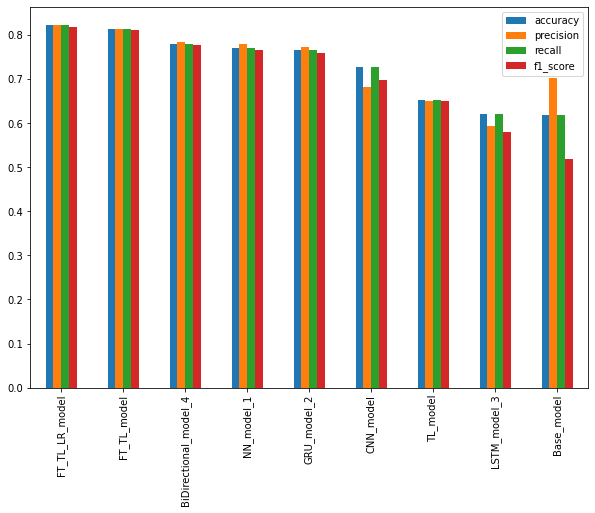

In [ ]:
final_metrics.sort_values("f1_score",ascending=False).plot(kind="bar",figsize=(10,7))

##Testing the model 🐱‍👤

In [ ]:
test_dir = "/content/test.txt"
test_df = pd.read_csv(test_dir,names=["Text"])
test_df

,Text
0,im feeling rather rotten so im not very ambiti...
1,im updating my blog because i feel shitty;sadness
2,i never make her separate from me because i do...
3,i left with my bouquet of red and yellow tulip...
4,i was feeling a little vain when i did this on...
...,...
1995,i just keep feeling like someone is being unki...
1996,im feeling a little cranky negative after this...
1997,i feel that i am useful to my people and that ...
1998,im feeling more comfortable with derby i feel ...


In [ ]:
test_data = [test_df["Text"][i].split(";")for i in range(len(test_df))]

In [ ]:
class predict():
  def __init__(self,model,class_names,data,o_class):
    self.model = model
    self.class_names=class_names
    self.data = data
    self.o_class = o_class
    self.pred_class=None
    self.pred_prob= None
  
  def prediction(self):
    model = self.model
    pred = model.predict(tf.expand_dims(self.data,axis=0))
    pred_probs = pred.max()
    pred_index = tf.argmax(pred[0],axis=0)
    class_name = self.class_names[pred_index]
    self.pred_class = class_name
    self.pred_prob = pred_probs
    return class_name,pred_probs
  
  def text_with_pred(self):
    print(f"the text is :\n{self.data} \n the predicted class is : {self.pred_class}")
    print(f"the original class is :) : {self.o_class}")

In [ ]:
test_data_text = [test_data[i][0]for i in range(len(test_data))]
label = [test_data[i][1]for i in range(len(test_data))]

In [ ]:
test_df = pd.DataFrame([test_data_text,label])
test_df = test_df.T

In [ ]:
test_text = test_df[0]
test_text

0       im feeling rather rotten so im not very ambiti...
1               im updating my blog because i feel shitty
2       i never make her separate from me because i do...
3       i left with my bouquet of red and yellow tulip...
4         i was feeling a little vain when i did this one
                              ...                        
1995    i just keep feeling like someone is being unki...
1996    im feeling a little cranky negative after this...
1997    i feel that i am useful to my people and that ...
1998    im feeling more comfortable with derby i feel ...
1999    i feel all weird when i have to meet w people ...
Name: 0, Length: 2000, dtype: object

In [ ]:
lab = le.transform(test_df[1])
lab

array([4, 4, 4, ..., 2, 2, 1])

In [ ]:
test_dat = ["it's so messed up","None"]

In [ ]:
make_pred = predict(model_9,class_names,test_dat[0],test_dat[1])
make_pred.prediction()

1/1 [==============================] - 0s 19ms/step


('sadness', 0.6600955)

In [ ]:
make_pred.text_with_pred()

the text is :
it's so messed up 
 the predicted class is : sadness
the original class is :) : None


##Confusion_matrix🤓

In [ ]:
lab_l = lab.tolist()

In [ ]:
test_df["lable"] = lab_l
test_df

,0,1,lable
0,im feeling rather rotten so im not very ambiti...,sadness,4
1,im updating my blog because i feel shitty,sadness,4
2,i never make her separate from me because i do...,sadness,4
3,i left with my bouquet of red and yellow tulip...,joy,2
4,i was feeling a little vain when i did this one,sadness,4
...,...,...,...
1995,i just keep feeling like someone is being unki...,anger,0
1996,im feeling a little cranky negative after this...,anger,0
1997,i feel that i am useful to my people and that ...,joy,2
1998,im feeling more comfortable with derby i feel ...,joy,2


In [ ]:
test_data,test_1_data,test_label,test_1_label = train_test_split(test_text,test_df["lable"],test_size=0.2)
test_data.shape,test_1_data.shape

((1600,), (400,))

In [ ]:
pred = model_9.predict(test_data)
pred

50/50 [==============================] - 0s 9ms/step


array([[0.0128659 , 0.00823489, 0.01030783, 0.00621504, 0.9542286 ,
        0.00814775],
       [0.00884974, 0.00853089, 0.9308441 , 0.02514934, 0.01862314,
        0.00800278],
       [0.02918915, 0.7816608 , 0.01648967, 0.05605145, 0.02834915,
        0.08825978],
       ...,
       [0.31207636, 0.01558615, 0.06510009, 0.01625547, 0.5821817 ,
        0.00880029],
       [0.00622306, 0.00697721, 0.94521314, 0.01706574, 0.01432151,
        0.01019933],
       [0.5570331 , 0.01304414, 0.01501546, 0.04759273, 0.34726617,
        0.0200484 ]], dtype=float32)

In [ ]:
pred = tf.argmax(pred,axis=1)
pred

<tf.Tensor: shape=(1600,), dtype=int64, numpy=array([4, 2, 1, ..., 4, 2, 0])>

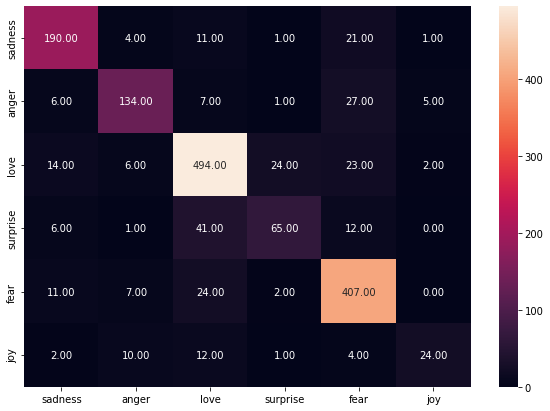

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_label,pred)
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt=".2f",xticklabels=[i for i in class_names],yticklabels=[i for i in class_names])

In [ ]:
model_9.evaluate(test_data,test_label)

50/50 [==============================] - 0s 10ms/step - loss: 0.5206 - accuracy: 0.8213


[0.5206258893013, 0.8212500214576721]